# Drafting for 3 and D
### Predicting the best shooters from NCAA production and their height to wingspan ratio.

Watching the draft this year I heard a lot of talk about wingspan and shooting ability. Wingspan and length have always been key attributes for any level of basketball. Long arms are more important than height alone since long arms help in rebounding, contesting shots, deflections, getting steals and just generally making it hard on the offense. Shooting is also very important but 3 point shooting has become even more important in today's modern NBA. Outside of the lottery draft picks, it becomes a crapshoot to try to predict who will be successful.

A lot of players outside of the lottery won't turn into All Stars but they can turn into solid role players. Every team needs guys to play a role alongside their superstar. One of the most popular current roles is a “3 and D” guy. Someone that can hit threes and play solid defense against opposing players. Historically guys like Robert Horry, Doug Christie, and Shawn Marion or more recently Danny Green, Draymond Green, Kawhi (superstar?), Trevor Ariza and others are great examples.

So I decided to look at some basic NCAA stats(no foreign stats due to inefficiency in finding data), mainly NCAA 3PT% and NCAA FT%, to predict NBA 3PT%. Also I wanted to analyze the wingspan to height ratio of players to determine their length attribute.


## Importing the Modules and Getting the Data
I used [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) and requests for scraping and parsing data from [Basketball Reference](http://www.basketball-reference.com/). Also I used [seaborn](https://web.stanford.edu/~mwaskom/software/seaborn/) for creating some pretty data visualization. Here I also created my helper functions for accessing the webpage and finding the html table as well as the function to loop through all of the players and retrieve their stats.

In [134]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def get_cbb_game_table(player):
    url = "http://www.sports-reference.com/cbb/players/%s-1.html" % (player)
    r = requests.get(url).text
    soup = BeautifulSoup(r, 'lxml')
    perGame = soup.find(id='players_per_game')
    return perGame

def get_stats(playersDF):
    shooters = playersDF["Player"].str.replace(' ','-').str.lower()
    playersDF['Player'] = shooters
    #get ncaa stats from url 
    headerTable = get_cbb_game_table(shooters[0])

    #get column names
    header = headerTable.find('thead').findAll('th', text=True)
    colNames = ['Player']
    for name in header:
        colNames.append(name.get_text())
    stats = []
    #get totals for each player
    for p in shooters:
        perGame = get_cbb_game_table(p)
        #if player has ncaa stats available
        if perGame:
            perGameTotals =perGame.find('tfoot').findAll('td') 
            statRow = [p]
            for stat in perGameTotals:
                statRow.append(stat.get_text())
            #handle ncaa transfer stats AKA toney douglas rule First 25 values only
            stats.append(statRow[0:25])
        #else remove from nba dataframe
        else:
            playersDF = playersDF[shooters != p]
    statsDF = pd.DataFrame(stats, columns = colNames)
    statsDF = statsDF.apply(pd.to_numeric, errors = 'ignore')
    return statsDF

In [135]:
#previously downloaded a csv with all NBA players from 2000-2016 with 3 point attemps > 300
#thanks to http://www.basketball-reference.com
nba = pd.read_csv("3PAgreater300.csv")
ncaa = get_stats(nba)



/home/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Tidying Up the Data
I chose to only accept players who shot at least 1 three point attempt per game in college and I merged the ncaa dataframe with the nba data frame into one data frame called shot_data.

In [136]:
#only accepting players who took at least 1 3PA per game in college
ncaa = ncaa[ncaa['3PA']>1]

In [137]:
shot_data = ncaa[['Player',"3P%","FT%"]]
shot_data=shot_data.rename(columns = {'3P%':'ncaa_3P','FT%':'ncaa_FT'})
shot_data.Player = shot_data.Player.str.replace("-"," ")
shot_data.Player = shot_data.Player.str.title()
shot_data.Player = shot_data.Player.str.strip()
shot_data = pd.merge(pd.DataFrame(shot_data),pd.DataFrame(nba[["Player","3P%"]]),left_index=True,right_index=True)
shot_data=shot_data.rename(columns = {'3P%':'3P'})

## Checking for Normality of the Independent Variables


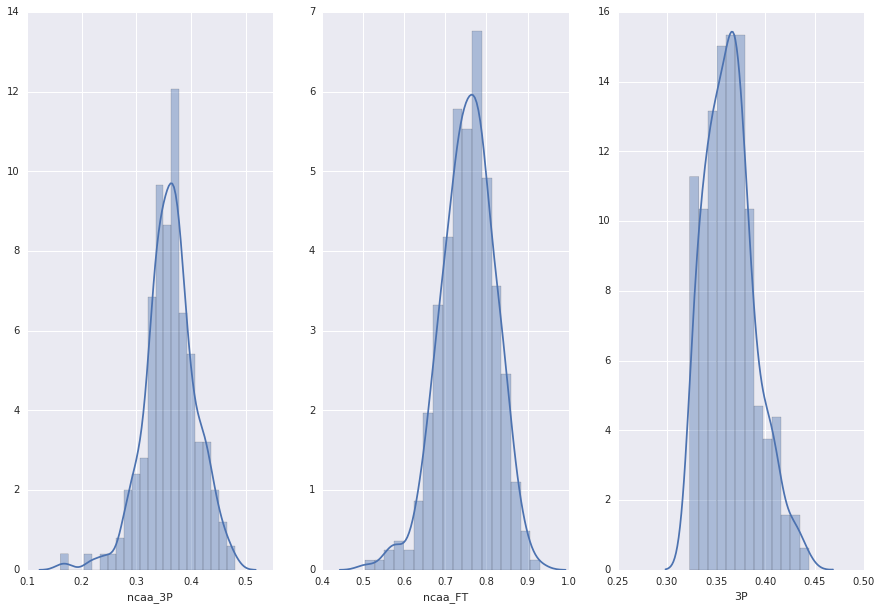

In [138]:
#shot_data.hist( alpha=0.5, bins=20, layout=(1,3), figsize=(20,10))
f, axs = plt.subplots(1,3,figsize=(15,10))

plt.subplot(1,3,1)
sns.distplot(shot_data['ncaa_3P'])

plt.subplot(1,3,2)
sns.distplot(shot_data['ncaa_FT'])

plt.subplot(1,3,3)
sns.distplot(shot_data['3P'])

## Finding and Removing Outliers
Outliers can have a negative effect on linear regression so I decided to remove any outliers. I used the basic definition for outliers as any value less than 1.5*Lower Quartile and greater than 1.5*Upper Quartile.

In [139]:
#basic outlier test:omit observation if abs_val of observation > 1.5*IQR
q1 = shot_data.quantile(.25)
q3= shot_data.quantile(.75)
iqr = pd.concat([q1, q3], axis=1, keys=['q1', 'q3'])
iqr['iqr'] = iqr['q3'] - iqr['q1']
iqr['max'] = iqr['q3'] + 1.5*iqr['iqr']
iqr['min'] = iqr['q1'] - 1.5*iqr['iqr']

iqr.head()

,q1,q3,iqr,max,min
ncaa_3P,0.3360,0.3880,0.0520,0.46600,0.25800
ncaa_FT,0.7135,0.7975,0.0840,0.92350,0.58750
3P,0.3450,0.3785,0.0335,0.42875,0.29475


In [140]:
#exlude outliers
shot_data = shot_data[shot_data['ncaa_3P']<iqr['max'][0]]
shot_data = shot_data[shot_data['ncaa_FT']<iqr['max'][1]]
shot_data = shot_data[shot_data['ncaa_3P']>iqr['min'][0]]
shot_data = shot_data[shot_data['ncaa_FT']>iqr['min'][1]]

print(shot_data)

                    Player_x  ncaa_3P  ncaa_FT                  Player_y  \
0              Stephen Curry    0.412    0.876             stephen-curry   
1               Hubert Davis    0.435    0.819              hubert-davis   
2               Jason Kapono    0.446    0.830              jason-kapono   
3                 Steve Nash    0.401    0.867                steve-nash   
4              Wesley Person    0.441    0.747             wesley-person   
6                Kyle Korver    0.453    0.891               kyle-korver   
7                Danny Ferry    0.388    0.775               danny-ferry   
8             Anthony Morrow    0.421    0.867            anthony-morrow   
9              Klay Thompson    0.390    0.827              terry-porter   
10               Brent Barry    0.345    0.794             klay-thompson   
11               Matt Bonner    0.395    0.740               brent-barry   
12                 Jon Barry    0.371    0.717               matt-bonner   
13          

## Regression Analysis
After running the regression analysis I was able to calculate my coefficients for my formula as well as the R-squared value. Notice the R-squared value is really low which can be problematic. To look at this model more in depth I took a look at the residuals.

In [141]:
#set up and run ordinary least squares regression
Y = shot_data["3P"]
X = shot_data[["ncaa_3P","ncaa_FT"]]
X = sm.add_constant(X)

result = sm.OLS(Y,X, missing = "drop").fit()
print(result.summary())
shot_data_pred = shot_data
shot_data_pred['pred'] = result.fittedvalues
shot_data_pred['resid'] = result.resid
print(shot_data_pred[["Player_x","3P",'pred']])

                            OLS Regression Results                            
Dep. Variable:                     3P   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     40.05
Date:                Fri, 08 Jul 2016   Prob (F-statistic):           2.87e-16
Time:                        07:27:38   Log-Likelihood:                 779.47
No. Observations:                 327   AIC:                            -1553.
Df Residuals:                     324   BIC:                            -1542.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2213      0.017     13.286      0.0

## Residuals
Taking a look at the residuals can help determine what might be wrong with this model.

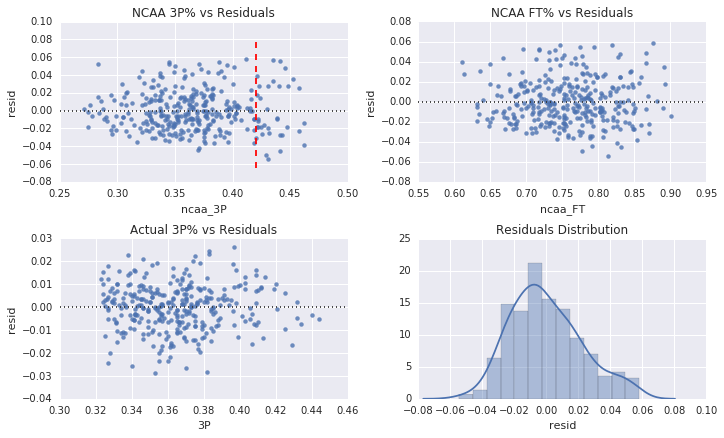

In [142]:
#check residual plots
f, axs = plt.subplots(2,2,figsize=(10,6))
plt.subplot(2,2,1)
sns.residplot(shot_data['ncaa_3P'],shot_data['resid'])
low = shot_data['resid'].min()
high = shot_data['resid'].max()
plt.plot((.42, .42), (low-.01,high+.02), 'r--')
plt.title("NCAA 3P% vs Residuals")

plt.subplot(2,2,2)
sns.residplot(shot_data['ncaa_FT'],shot_data['resid'])
plt.title("NCAA FT% vs Residuals")


plt.subplot(2,2,3)
ax0 = sns.residplot(shot_data['3P'],shot_data['resid'])
plt.title("Actual 3P% vs Residuals")

plt.subplot(2,2,4)
ax = sns.distplot(shot_data['resid'])
#plt.hist(shot_data['resid'])
plt.title("Residuals Distribution")
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)


Looking at the NCAA 3P% vs Residuals the model is not as accurate with NCAA 3P% greater than ~40%. The residuals show that this model might not be the best predictor especially for the extreme values such as 3P% > .40.


## Predicting Drafted College 3 and D Players
I will use the same model from above to predict 3 point percentage for all drafted NCAA players and also display their ratio of wingspan to height.

In [143]:
#previously downloaded csv from http://www.sports-reference.com
draft = pd.read_csv("draftees.csv")
draft_ncaa = get_stats(draft)
print (draft)


/home/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


    Pk   Tm              Player                          College
0    1  PHI         ben-simmons       Louisiana State University
1    2  LAL      brandon-ingram                  Duke University
2    3  BOS        jaylen-brown         University of California
3    5  MIN           kris-dunn               Providence College
4    6  NOP         buddy-hield           University of Oklahoma
5    7  DEN        jamal-murray           University of Kentucky
6    8  SAC    marquesse-chriss         University of Washington
7    9  TOR        jakob-poeltl               University of Utah
8   11  ORL    domantas-sabonis               Gonzaga University
9   12  UTA      taurean-prince                Baylor University
10  14  CHI    denzel-valentine        Michigan State University
11  17  MEM        wade-baldwin            Vanderbilt University
12  18  DET      henry-ellenson             Marquette University
13  19  DEN       malik-beasley         Florida State University
14  20  IND        caris-

In [144]:
#save to csv for easy access later
#draft_ncaa.to_csv("draft_ncaa.csv")

In [145]:
#draft_ncaa = pd.read_csv('draft_ncaa.csv')

In [146]:
draft = draft.merge(draft_ncaa, on='Player')
print(draft)

    Pk   Tm              Player                          College  Season  \
0    1  PHI         ben-simmons       Louisiana State University  Career   
1    2  LAL      brandon-ingram                  Duke University  Career   
2    3  BOS        jaylen-brown         University of California  Career   
3    5  MIN           kris-dunn               Providence College  Career   
4    6  NOP         buddy-hield           University of Oklahoma  Career   
5    7  DEN        jamal-murray           University of Kentucky  Career   
6    9  TOR        jakob-poeltl               University of Utah  Career   
7   11  ORL    domantas-sabonis               Gonzaga University  Career   
8   12  UTA      taurean-prince                Baylor University  Career   
9   14  CHI    denzel-valentine        Michigan State University  Career   
10  17  MEM        wade-baldwin            Vanderbilt University  Career   
11  18  DET      henry-ellenson             Marquette University  Career   
12  19  DEN 

In [147]:
#use results from nba analysis to predict 3P% for draftees
X_draft = draft[["3P%","FT%"]]
X_draft = sm.add_constant(X_draft)

#add the prediction to the draft dataframe
draft["pred"] = result.predict(X_draft)


Now I will bring in the wingspan information provided from [http://www.nbadraft.net/2016-nba-draft-combine-measurements](http://www.nbadraft.net/2016-nba-draft-combine-measurements).

In [148]:
ws = pd.read_csv('wingspan.csv')
ws.head()
draft.head()
draft = draft.merge(ws, on='Player')
draft_sorted = draft[['Player','Tm','FT%','3P%','pred','Ratio']]
draft_sorted = draft_sorted.sort_values(by='pred', ascending = False)

print(draft_sorted)

                Player   Tm    FT%    3P%      pred  Ratio
8         wade-baldwin  MEM  0.800  0.422  0.378774   1.12
20     malcolm-brogdon  MIL  0.876  0.365  0.378240   1.09
4          buddy-hield  NOP  0.836  0.390  0.377723   1.07
31        marcus-paige  BRK  0.844  0.375  0.376231   1.08
19          tyler-ulis  PHO  0.846  0.371  0.375818   1.08
10       malik-beasley  DEN  0.813  0.387  0.374653   1.05
7     denzel-valentine  CHI  0.779  0.408  0.374174   1.09
11        caris-levert  IND  0.770  0.401  0.372043   1.05
25   demetrius-jackson  BOS  0.837  0.348  0.371134   1.08
28       georges-niang  IND  0.763  0.375  0.367106   1.04
33      isaiah-cousins  SAC  0.711  0.407  0.366354   1.04
22       patrick-mccaw  MIL  0.753  0.367  0.364703   1.06
26         jake-layman  ORL  0.759  0.362  0.364581   1.02
24    isaiah-whitehead  UTA  0.757  0.359  0.363877   1.07
1       brandon-ingram  LAL  0.682  0.410  0.363566   1.09
6       taurean-prince  UTA  0.718  0.376  0.362196   1.

## Conclusion
What stands out to me is that Wade Baldwin is at the top of both my predicted 3P% as well as having the highest wingspan to height ratio. I think Memphis has a solid young (20 yo) backup point guard to Conley and possibly a great 3 and D contributor. According to my model no one else can compare with Baldwin but other standouts include Malcolm Brogdon, Brandon Ingram, and Malachi Richardson. 

With league average 3P% of 35.4% last year and average wingspan ratio of ~1.6 I would expect anyone with above average 3P% and above average ratio to have the ability to be a solid 3 and D player at the least. So below is the list of all players with pred > 35.4% and Ratio > 1.06.

In [149]:
threeAndD = draft_sorted[draft_sorted['pred'] > .354]
threeAndD = threeAndD[threeAndD['Ratio'] > 1.06]
threeAndD = threeAndD.dropna()
print(threeAndD)

                Player   Tm    FT%    3P%      pred  Ratio
8         wade-baldwin  MEM  0.800  0.422  0.378774   1.12
20     malcolm-brogdon  MIL  0.876  0.365  0.378240   1.09
4          buddy-hield  NOP  0.836  0.390  0.377723   1.07
31        marcus-paige  BRK  0.844  0.375  0.376231   1.08
19          tyler-ulis  PHO  0.846  0.371  0.375818   1.08
7     denzel-valentine  CHI  0.779  0.408  0.374174   1.09
25   demetrius-jackson  BOS  0.837  0.348  0.371134   1.08
24    isaiah-whitehead  UTA  0.757  0.359  0.363877   1.07
1       brandon-ingram  LAL  0.682  0.410  0.363566   1.09
30       joel-bolomboy  UTA  0.713  0.371  0.360835   1.08
13  malachi-richardson  CHO  0.720  0.353  0.358751   1.09
29          ben-bentil  BOS  0.761  0.324  0.358742   1.08
3            kris-dunn  MIN  0.693  0.354  0.355869   1.09


Typically it seems rookies and even second year players struggle on the defensive end until they can adjust to the NBA competition. However looking at the recent players coming from college I would expect these players to be possible contributors to floor spacing and defensive disruptions in the near future.

In [151]:
threeAndD.head(len(threeAndD))

,Player,Tm,FT%,3P%,pred,Ratio
8,wade-baldwin,MEM,0.800,0.422,0.378774,1.12
20,malcolm-brogdon,MIL,0.876,0.365,0.378240,1.09
4,buddy-hield,NOP,0.836,0.390,0.377723,1.07
31,marcus-paige,BRK,0.844,0.375,0.376231,1.08
19,tyler-ulis,PHO,0.846,0.371,0.375818,1.08
7,denzel-valentine,CHI,0.779,0.408,0.374174,1.09
25,demetrius-jackson,BOS,0.837,0.348,0.371134,1.08
24,isaiah-whitehead,UTA,0.757,0.359,0.363877,1.07
1,brandon-ingram,LAL,0.682,0.410,0.363566,1.09
30,joel-bolomboy,UTA,0.713,0.371,0.360835,1.08
